In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [77]:
def process_accelerometer_file(file_path):
    """
    Cleans and processes accelerometer data, ensuring no unnecessary NaNs.
    :param file_path: Path to the accelerometer data file.
    :return: DataFrame containing cleaned accelerometer data.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract data from each line
    accel_data = []
    for line in lines:
        parts = line.strip().split('\t')
        entry = {}
        valid_entry = True
        for part in parts:
            if ':' in part:  # Ensures valid key-value pair
                key, value = part.split(':')
                try:
                    if key.strip() == "Time":
                        entry["Time"] = float(value.strip())  # Time in seconds
                    else:
                        entry[key.strip()] = float(value.strip())
                except ValueError:
                    valid_entry = False  # Skip lines with invalid values
            else:
                valid_entry = False  # Skip lines without valid key-value pairs

        if valid_entry:
            accel_data.append(entry)

    # Convert to DataFrame
    df = pd.DataFrame(accel_data)

    # Drop rows with all NaN values (unlikely but extra precaution)
    df.dropna(how='all', inplace=True)

    return df

In [78]:
def process_position_file(file_path):
    """
    Cleans and processes position data from a CSV file, including converting hexadecimal
    timestamps to seconds.
    :param file_path: Path to the position CSV file.
    :return: DataFrame containing cleaned position data.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract raw column names and clean them
    raw_columns = lines[0].strip().split(';')
    cleaned_columns = [col.split(';')[0].strip() for col in raw_columns]

    # Read the data into a DataFrame
    data = pd.read_csv(file_path, skiprows=1, sep=';', names=cleaned_columns)

    # Convert Timestamp from hexadecimal to seconds
    if 'Timestamp' in data.columns:
        data['Timestamp'] = data['Timestamp'].apply(lambda x: int(x, 16) * 1e-6)  # Convert to seconds

    return data

In [79]:
def process_all_subfolders(main_folder_path):
    """
    Automatically processes all subfolders in the main folder for accelerometer and position data.
    :param main_folder_path: Main directory containing subfolders with jitter data.
    :return: Dictionary containing processed accelerometer and position data for each subfolder.
    """
    processed_data = {}

    for folder_name in os.listdir(main_folder_path):
        subfolder_path = os.path.join(main_folder_path, folder_name)
        if os.path.isdir(subfolder_path):  # Ensure it's a subfolder
            # Identify the accelerometer and position files
            accel_file = [file for file in os.listdir(subfolder_path) if file.endswith(".txt")]
            csv_file = [file for file in os.listdir(subfolder_path) if file.endswith(".csv")]

            if accel_file and csv_file:  # Ensure both files are present
                accel_file_path = os.path.join(subfolder_path, accel_file[0])
                csv_file_path = os.path.join(subfolder_path, csv_file[0])

                # Process files
                accel_data = process_accelerometer_file(accel_file_path)
                position_data = process_position_file(csv_file_path)

                # Extract the subfolder number (e.g., `_1` to `_12`) for labeling
                folder_label = int(folder_name.split('_')[-1])

                # Store the processed data with the folder label
                processed_data[folder_label] = {
                    'acceleration': accel_data,
                    'position': position_data
                }

    return processed_data

In [80]:
main_folder_path = "jitter_data"  # Replace with your actual path

# Process all subfolders
processed_data = process_all_subfolders(main_folder_path)

In [81]:
# Example: Access accelerometer and position data for folder 2
print("Accelerometer Data for Folder 2:")
print(processed_data[2]['acceleration'].head())

print("\nPosition Data for Folder 2:")
print(processed_data[2]['position'].head())

Accelerometer Data for Folder 2:
   Time      X     Y     Z
0  0.21  -4.09 -3.71 -6.16
1  0.22 -11.87 -5.71 -5.24
2  0.22  -8.30 -3.51 -5.80
3  0.22  -8.30 -3.51 -5.80
4  0.23  -7.75 -6.21 -9.74

Position Data for Folder 2:
     Timestamp  Index  TrackingId    CoordX   CoordY    CoordZ    R[0,0]  \
0  8020.247623      0       75685  170.2649 -96.6044  816.6901 -0.971441   
1  8020.262548      0       75685  170.2676 -96.6024  816.6890 -0.971440   
2  8020.268518      0       75685  170.2678 -96.6037  816.6870 -0.971449   
3  8020.277473      0       75685  170.2680 -96.6036  816.6911 -0.971443   
4  8020.283444      0       75685  170.2672 -96.6042  816.6898 -0.971454   

     R[0,1]    R[0,2]    R[1,0]  ...    R[2,1]    R[2,2]  Registration  \
0  0.004845  0.237234 -0.070630  ... -0.316539 -0.921134        0.0380   
1  0.004854  0.237237 -0.070630  ... -0.316565 -0.921124        0.0401   
2  0.004842  0.237197 -0.070634  ... -0.316587 -0.921128        0.0395   
3  0.004846  0.237224 -

In [82]:
print(processed_data.keys())

dict_keys([1, 10, 11, 12, 2, 3, 4, 5, 6])


In [83]:
def analyze_all_accelerometer_jitter(processed_data, output_folder):
    """
    Analyzes accelerometer jitter for all subfolders in processed_data, handles duplicate time points,
    saves results to CSVs, and displays FFT plots.
    :param processed_data: Dictionary containing accelerometer and position data for each folder.
    :param output_folder: Folder path to save the results.
    :return: Dictionary containing jitter metrics for all folders.
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    all_jitter_metrics = {}

    for folder_label in sorted(processed_data.keys()):  # Sort keys for consistent order
        accel_data = processed_data[folder_label]['acceleration']

        # Handle duplicate time points by averaging
        accel_data = accel_data.groupby('Time', as_index=False).mean()

        # Analyze accelerometer jitter for the current folder
        jitter_metrics = {}
        for axis in ['X', 'Y', 'Z']:
            # Convert signal and time columns to NumPy arrays
            signal = accel_data[axis].to_numpy()
            time = accel_data['Time'].to_numpy()

            # Calculate time differences
            time_diff = np.diff(time)
            if np.any(time_diff <= 0):  # Check for invalid time intervals
                raise ValueError(f"Invalid time intervals in folder {folder_label} for axis {axis}")

            # Use the mean time difference to compute frequency spacing
            mean_time_diff = np.mean(time_diff)
            n = len(signal)
            freq = fftfreq(n, d=mean_time_diff)
            fft_values = fft(signal)
            amplitudes = np.abs(fft_values)

            # Exclude DC component and focus on positive frequencies
            freq = freq[1:n // 2]
            amplitudes = amplitudes[1:n // 2]

            # Store results
            jitter_metrics[axis] = {
                "frequencies": freq,
                "amplitudes": amplitudes
            }

            # Save jitter metrics to CSV
            df = pd.DataFrame({
                'Frequency (Hz)': freq,
                'Amplitude': amplitudes
            })
            csv_path = os.path.join(output_folder, f"jitter_metrics_{folder_label}_{axis}.csv")
            df.to_csv(csv_path, index=False)

            # Plot FFT results
            plt.figure(figsize=(10, 6))
            plt.plot(freq, amplitudes, label=f'{axis}-Axis')
            plt.title(f'FFT of {axis}-Axis Accelerometer Data (Folder {folder_label})')
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid(True)
            plt.show()

        # Store metrics for this folder
        all_jitter_metrics[folder_label] = jitter_metrics

    return all_jitter_metrics


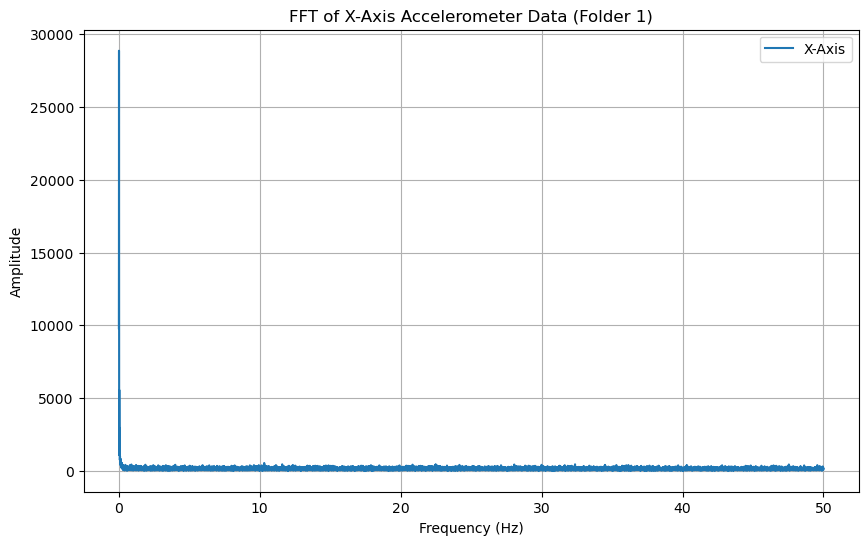

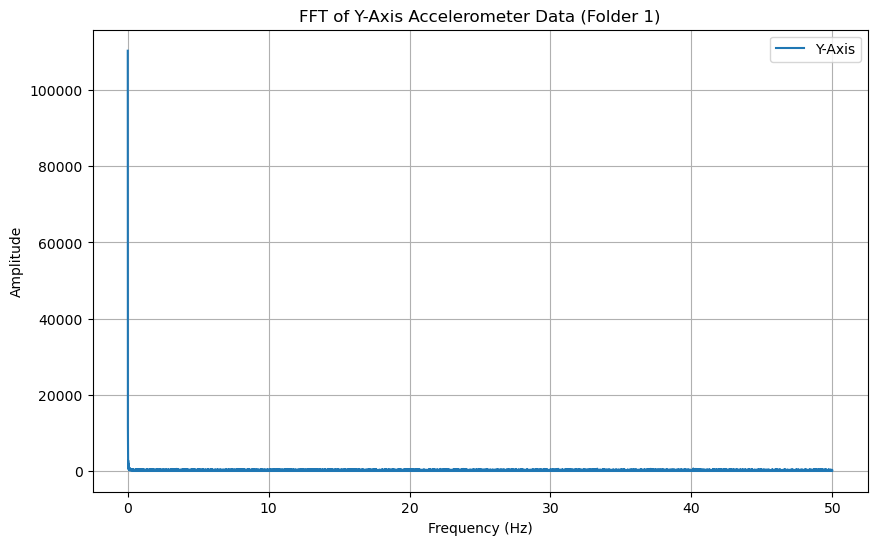

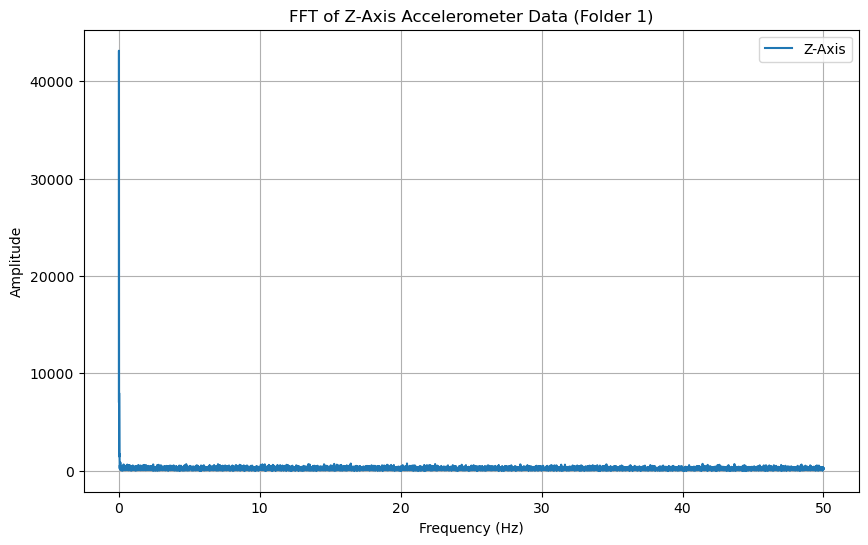

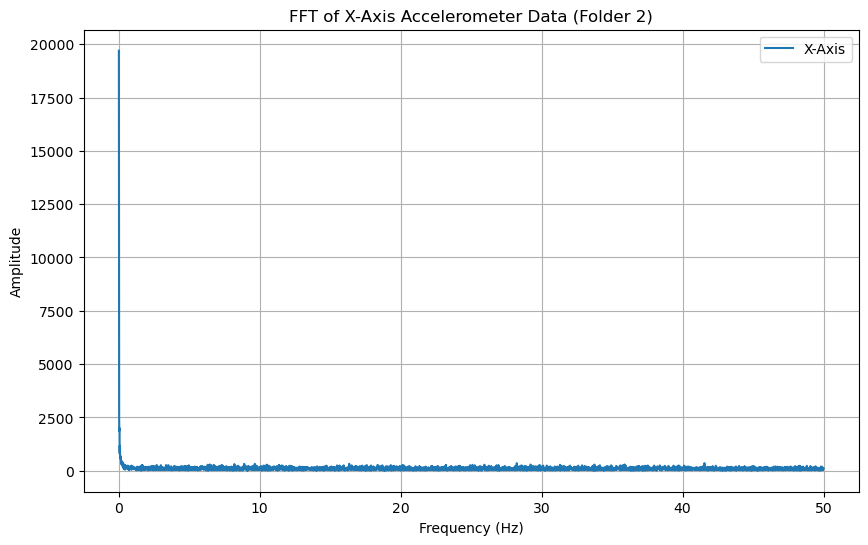

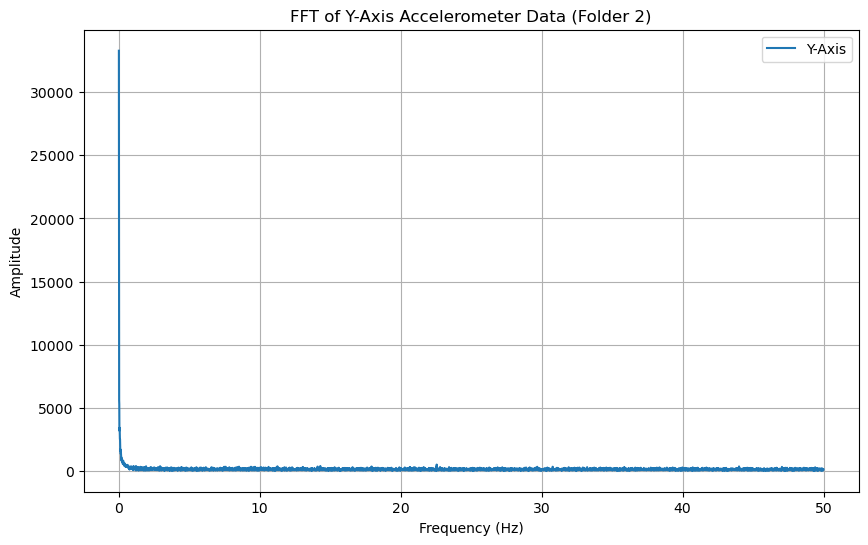

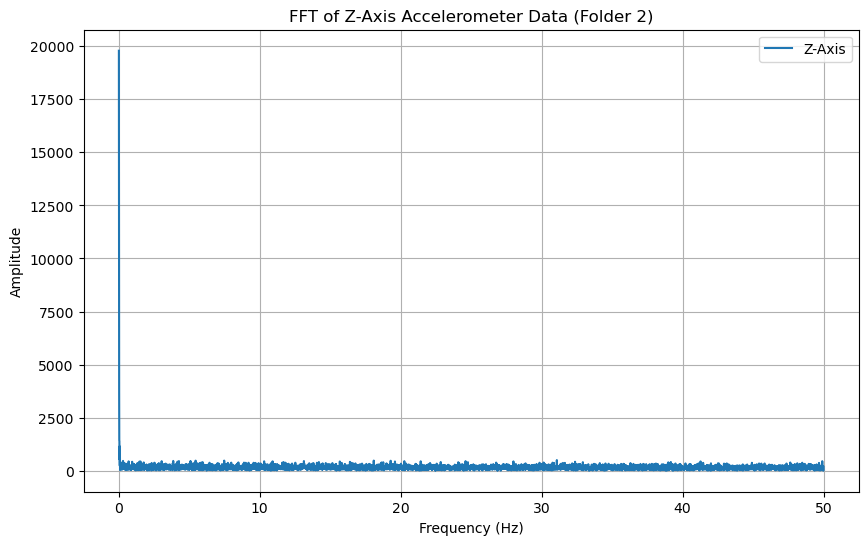

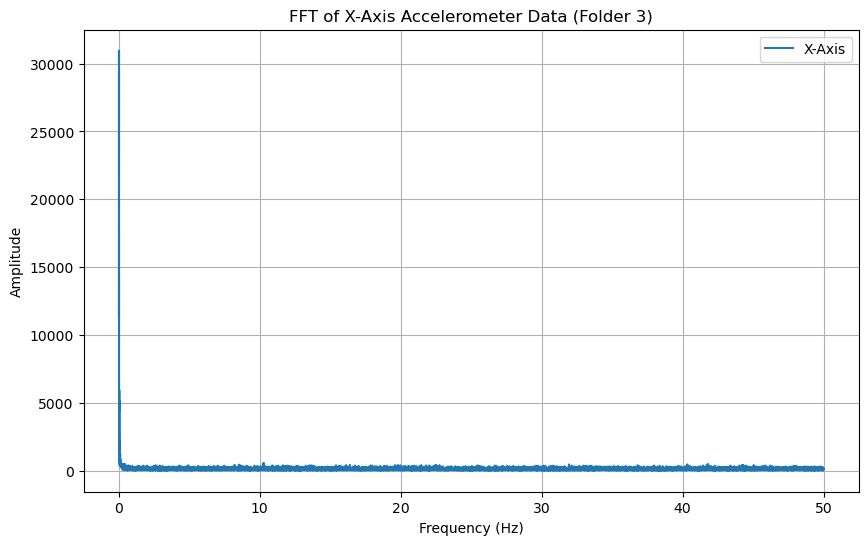

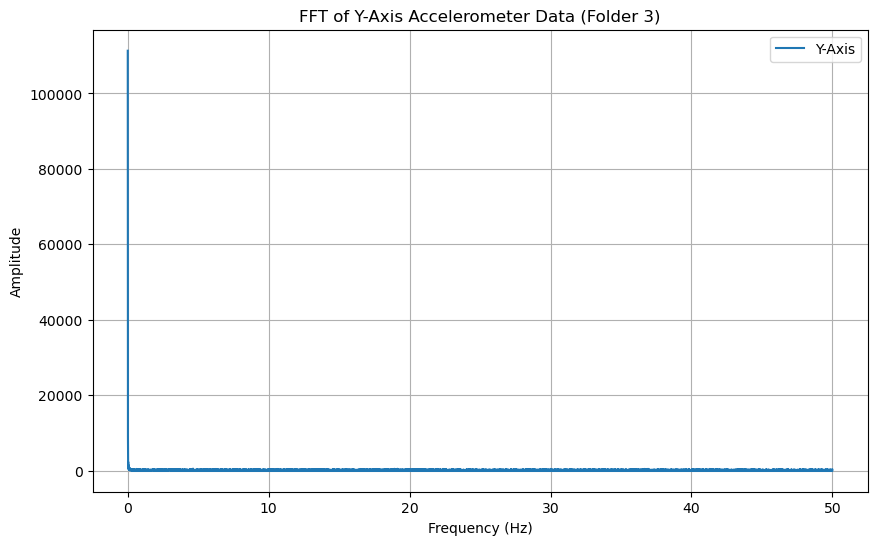

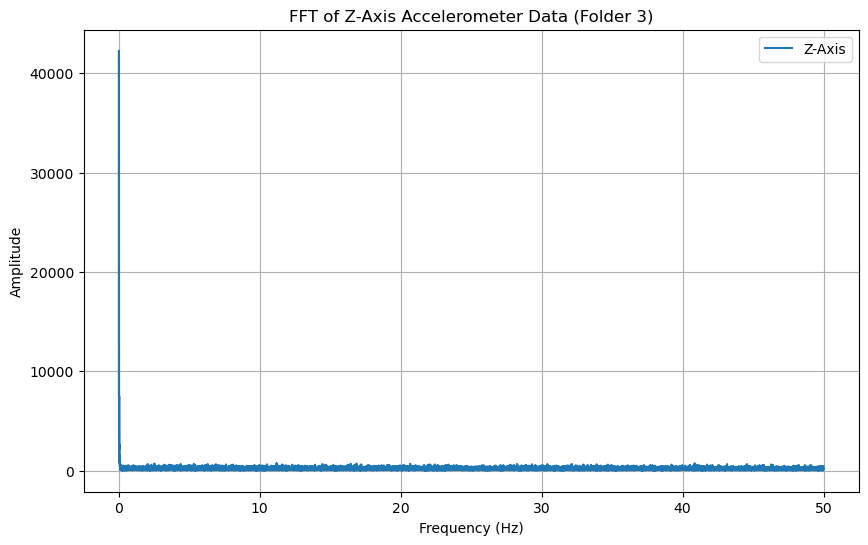

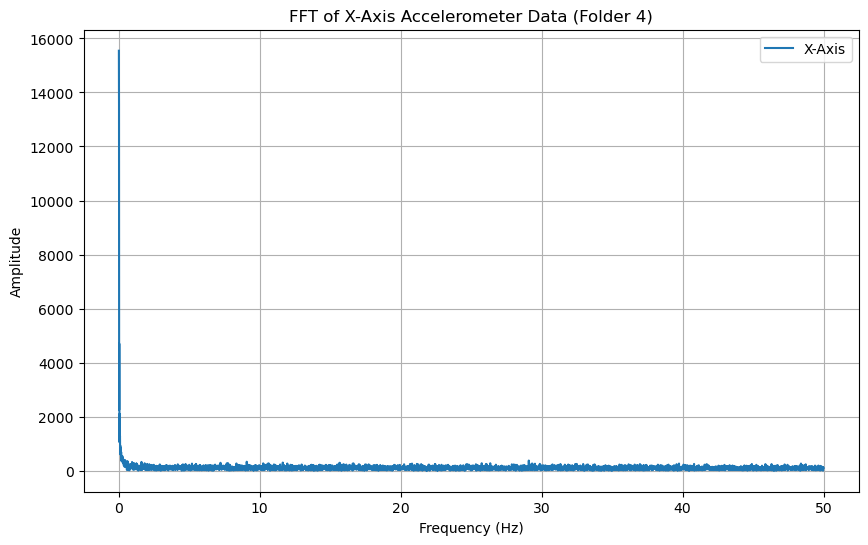

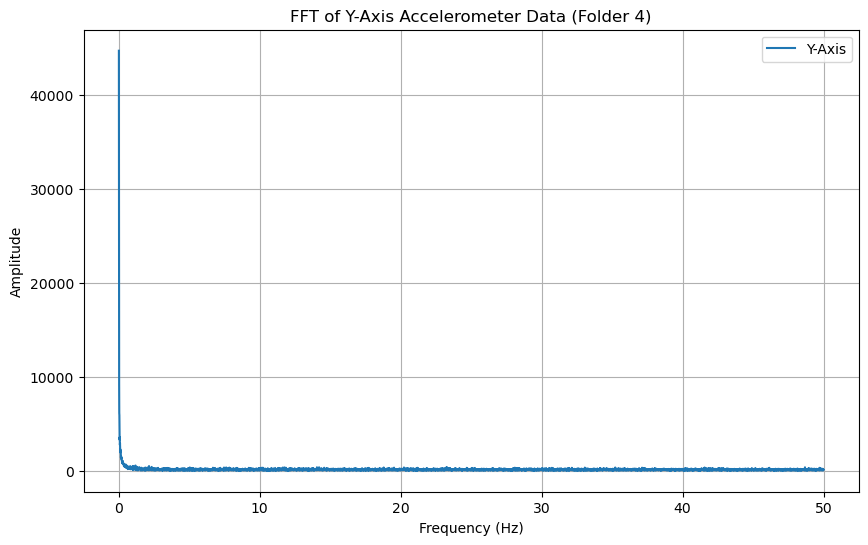

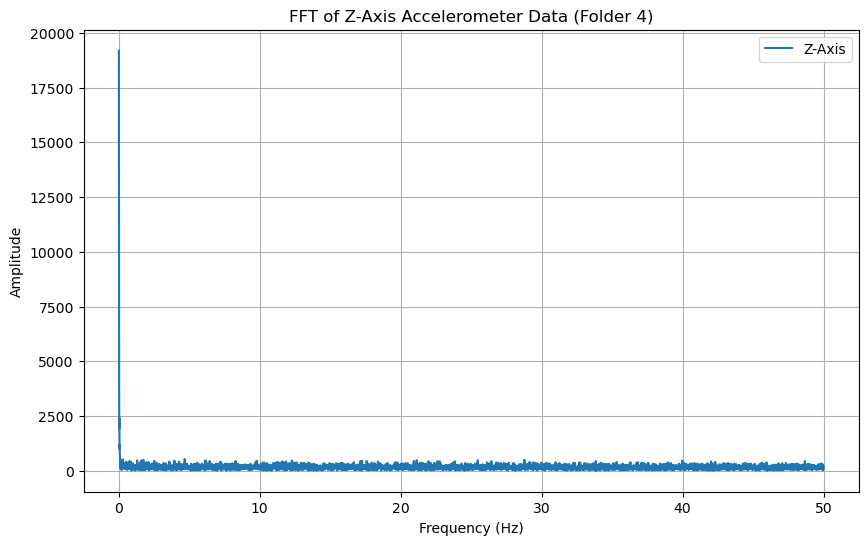

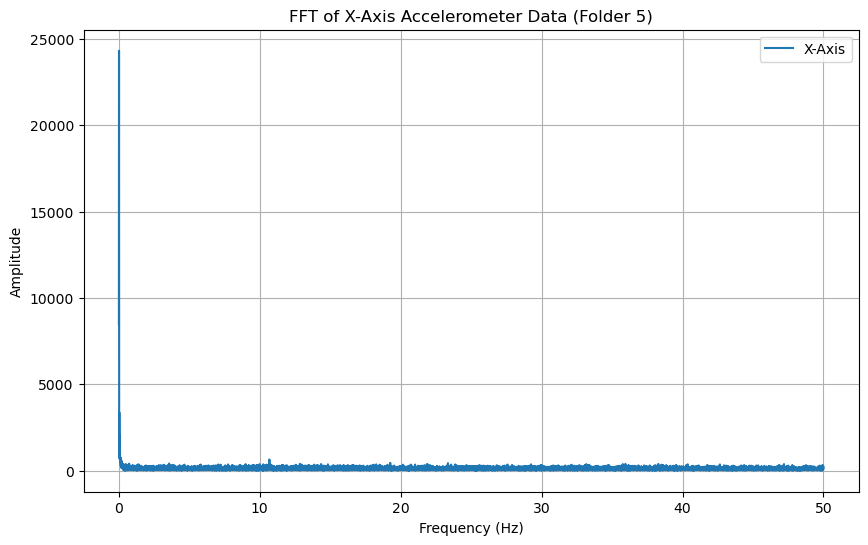

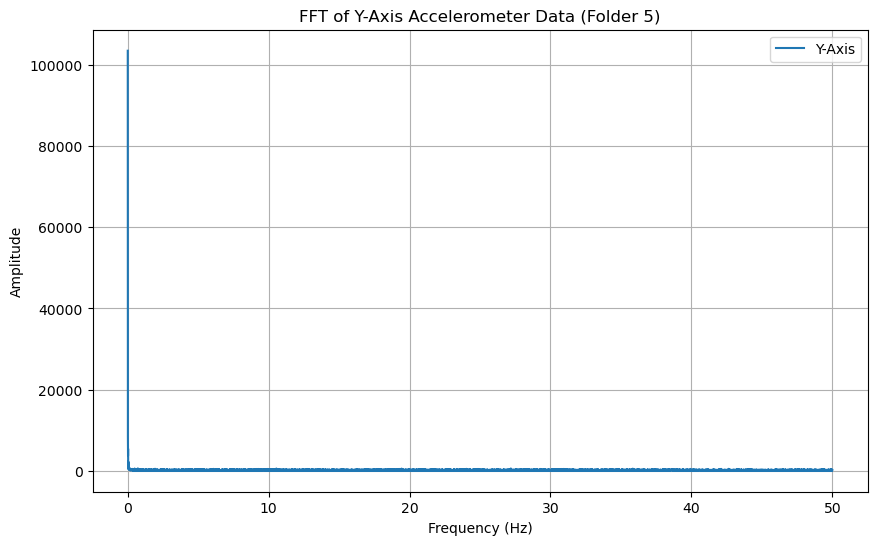

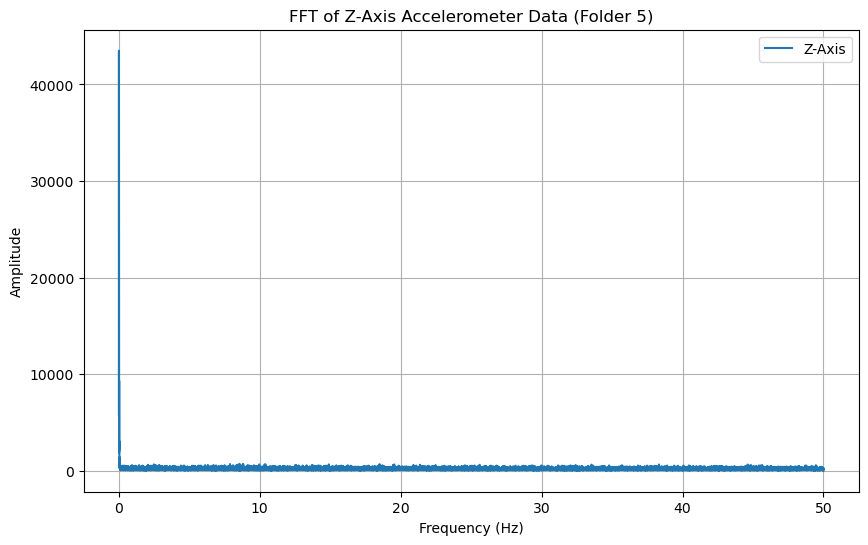

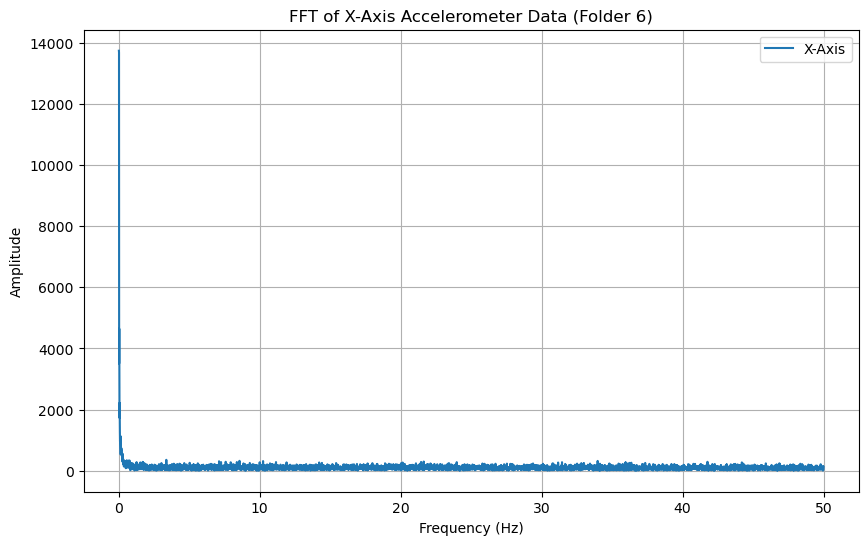

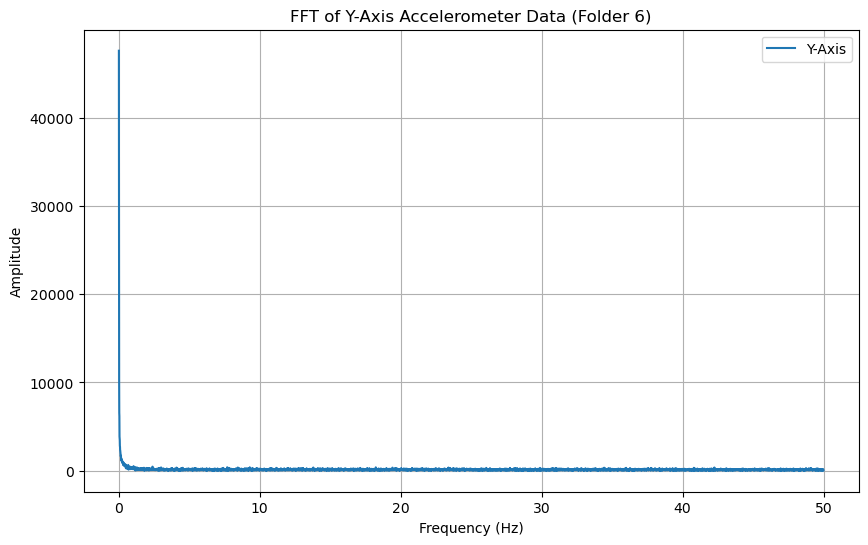

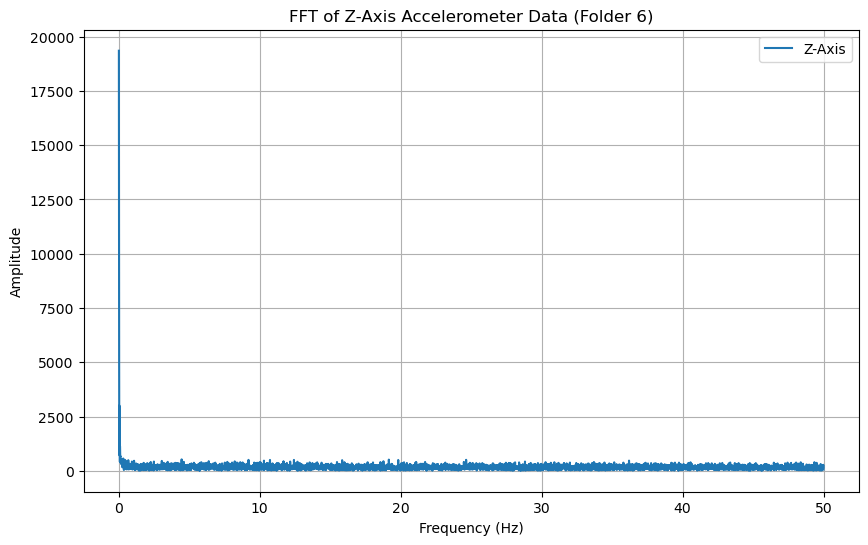

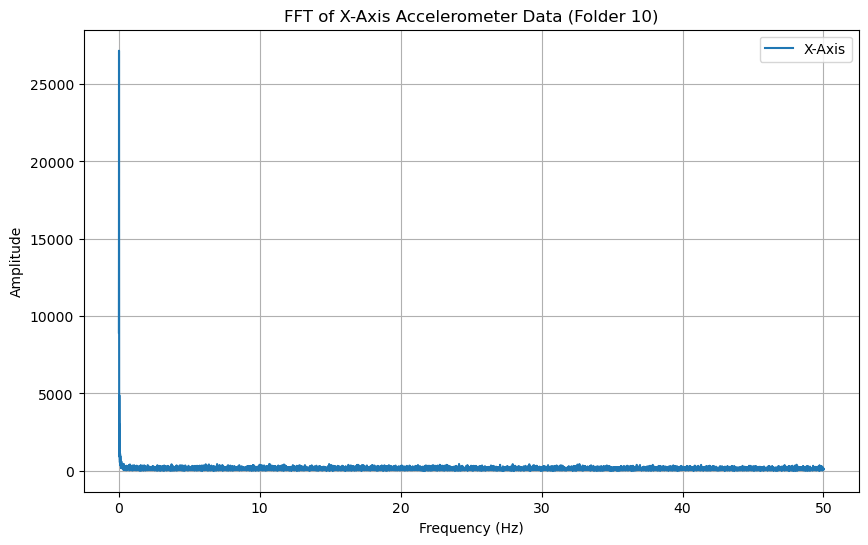

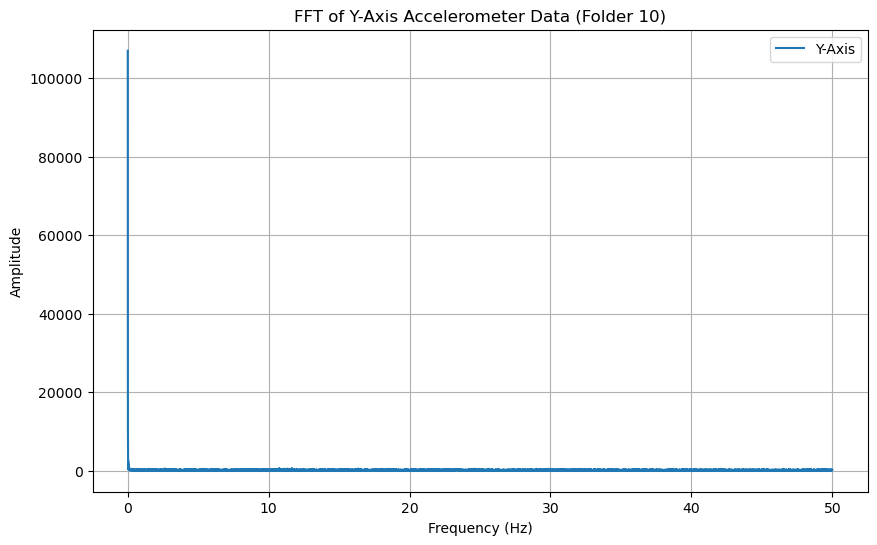

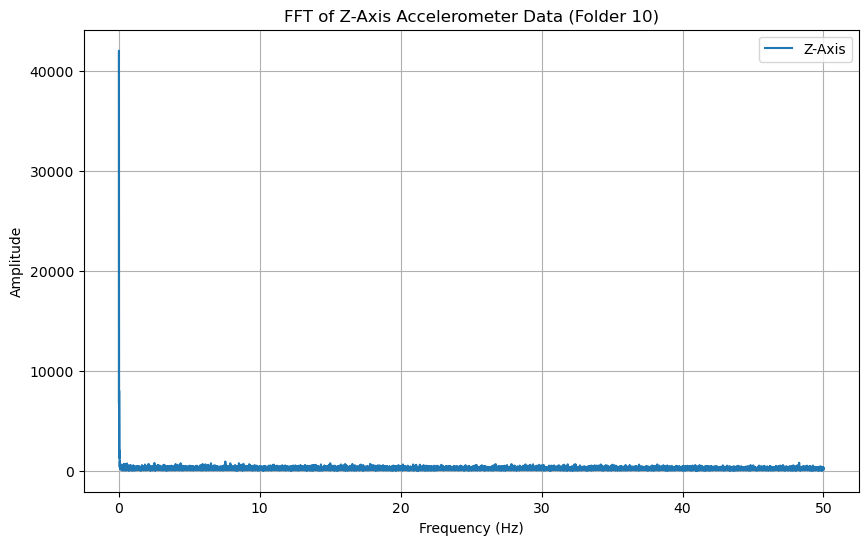

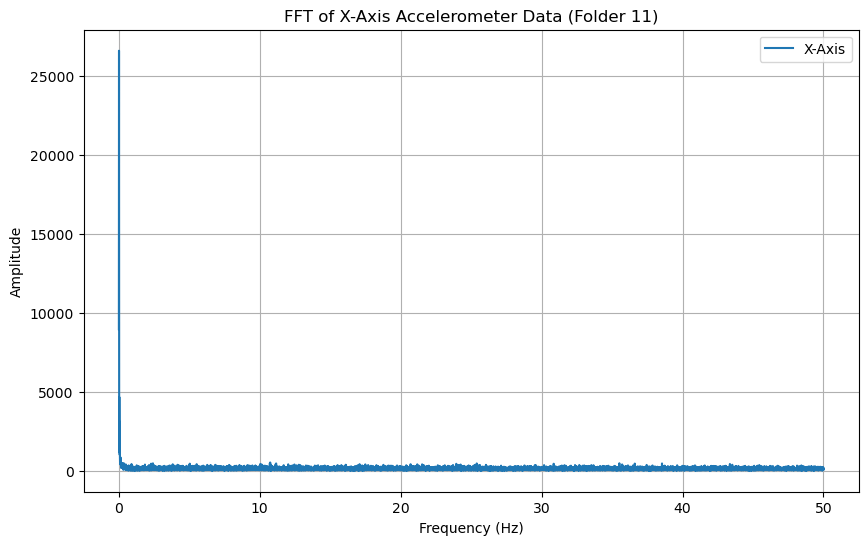

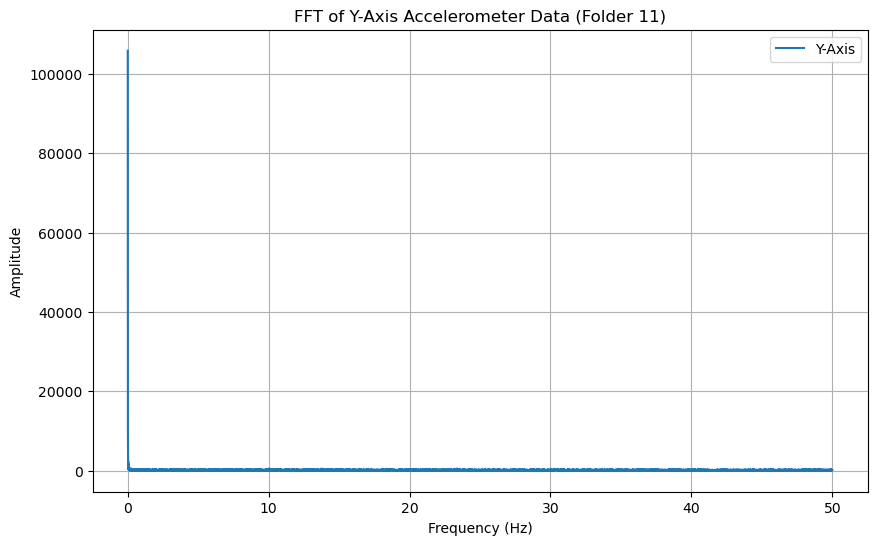

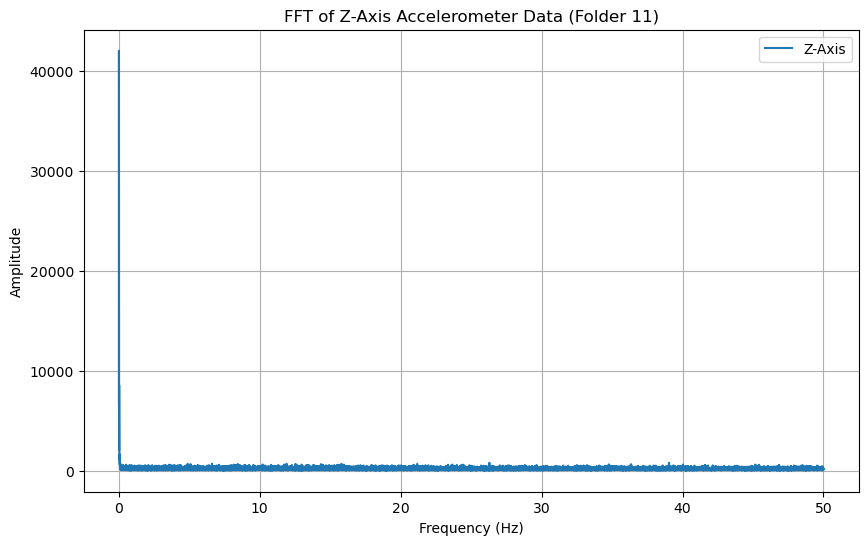

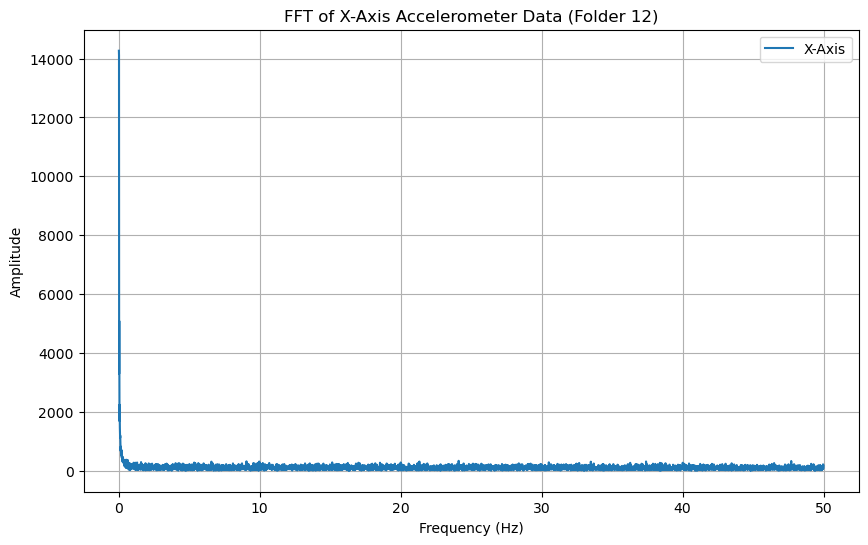

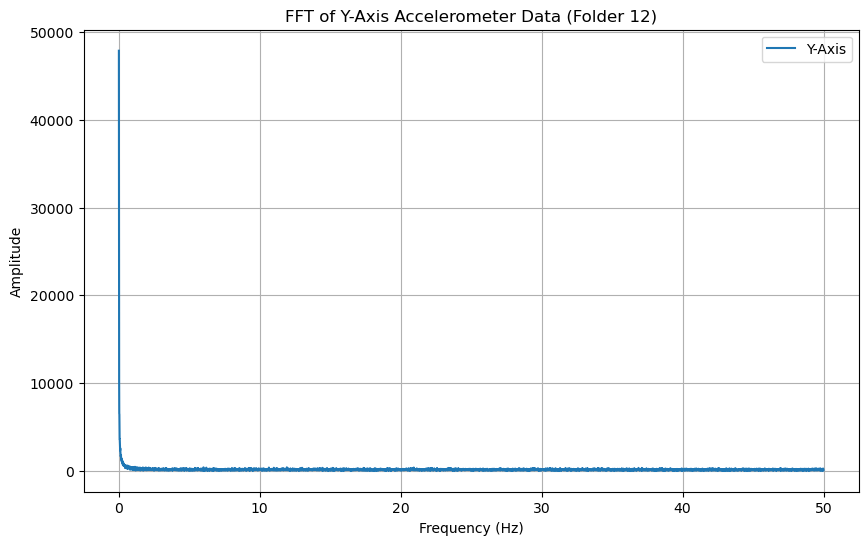

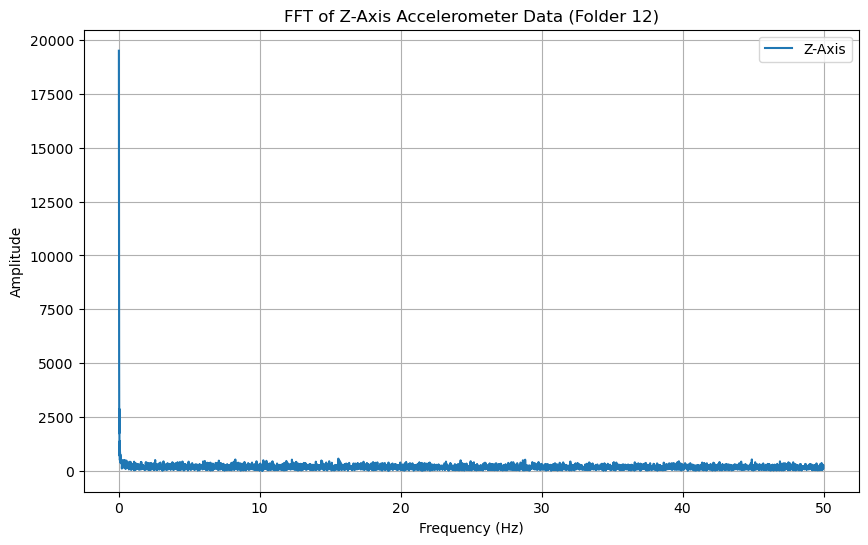

In [84]:
output_folder = "results/accel_jitter"  # Replace with desired path

# Analyze accelerometer jitter for all processed data
all_jitter_metrics = analyze_all_accelerometer_jitter(processed_data, output_folder)

In [85]:
def analyze_all_position_jitter(processed_data, output_folder):
    """
    Analyzes position jitter for all subfolders in processed_data, calculates relative errors,
    saves results to individual CSVs per folder, and displays plots for each folder.
    :param processed_data: Dictionary containing accelerometer and position data for each folder.
    :param output_folder: Folder path to save the results.
    :return: Dictionary containing position jitter metrics for all folders.
    """
    os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists
    all_position_metrics = {}

    for folder_label in sorted(processed_data.keys()):  # Sort keys for consistent order
        position_data = processed_data[folder_label]['position']

        # Calculate relative errors for each coordinate
        position_data['Error_X'] = position_data['CoordX'].diff().fillna(0)
        position_data['Error_Y'] = position_data['CoordY'].diff().fillna(0)
        position_data['Error_Z'] = position_data['CoordZ'].diff().fillna(0)

        # Combine errors into a magnitude of error
        position_data['Error_Magnitude'] = (
            position_data['Error_X']**2 + position_data['Error_Y']**2 + position_data['Error_Z']**2
        )**0.5

        # Save relative errors to CSV for this folder
        error_csv_path = os.path.join(output_folder, f"position_errors_{folder_label}.csv")
        position_data[['Timestamp', 'Error_X', 'Error_Y', 'Error_Z', 'Error_Magnitude']].to_csv(error_csv_path, index=False)

        # Plot original signals vs. time
        plt.figure(figsize=(12, 8))
        plt.plot(position_data['Timestamp'], position_data['CoordX'], label='CoordX')
        plt.plot(position_data['Timestamp'], position_data['CoordY'], label='CoordY')
        plt.plot(position_data['Timestamp'], position_data['CoordZ'], label='CoordZ')
        plt.title(f"Position vs. Time (Folder {folder_label})")
        plt.xlabel("Time (s)")
        plt.ylabel("Position (mm)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot jitter (relative error) vs. time
        plt.figure(figsize=(12, 8))
        plt.plot(position_data['Timestamp'], position_data['Error_Magnitude'], label='Error Magnitude', color='red')
        plt.axhline(y=1, color='green', linestyle='--', label='1 mm Threshold')  # Error limit
        plt.title(f"Jitter vs. Time (Relative Error, Folder {folder_label})")
        plt.xlabel("Time (s)")
        plt.ylabel("Error Magnitude (mm)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Store metrics for this folder
        max_error = position_data['Error_Magnitude'].max()
        exceeded_limit = max_error > 1
        all_position_metrics[folder_label] = {
            'Max_Error': max_error,
            'Exceeded_Limit': exceeded_limit
        }

    return all_position_metrics


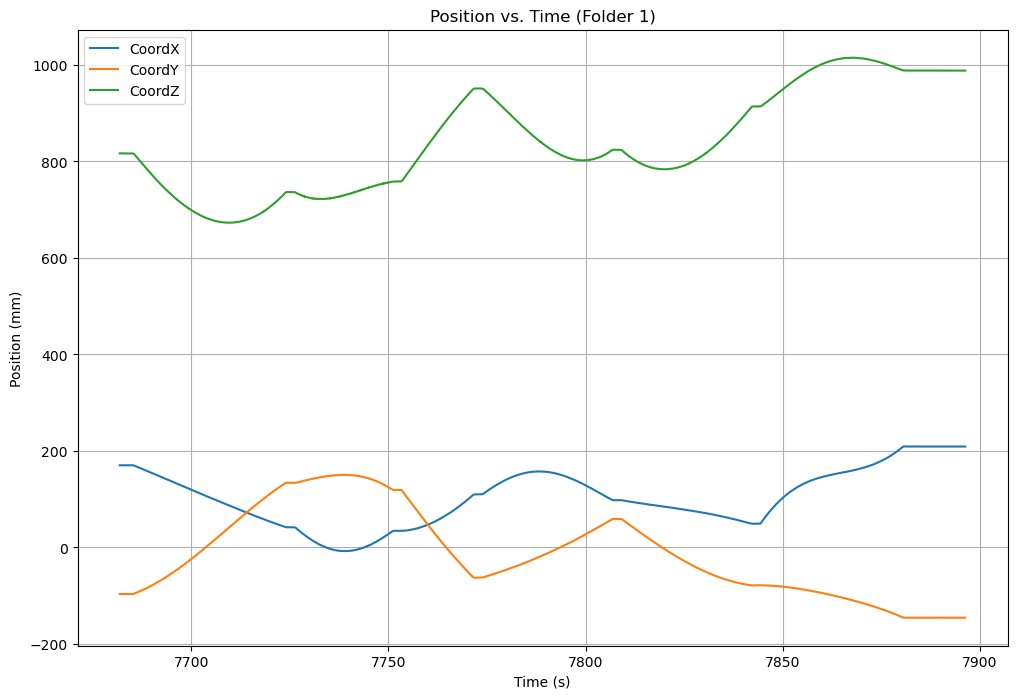

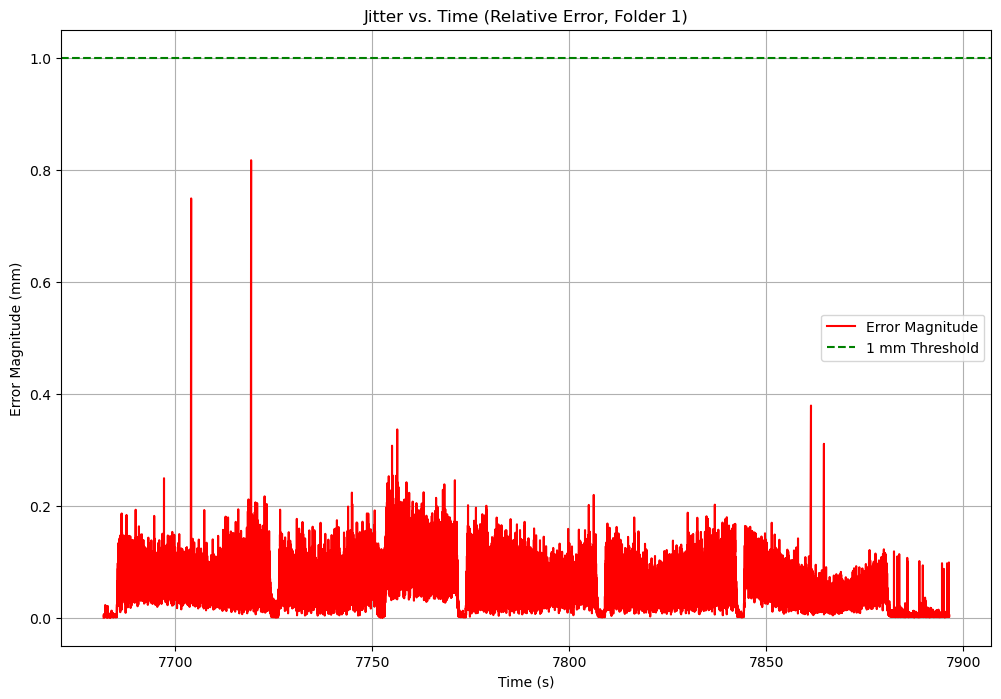

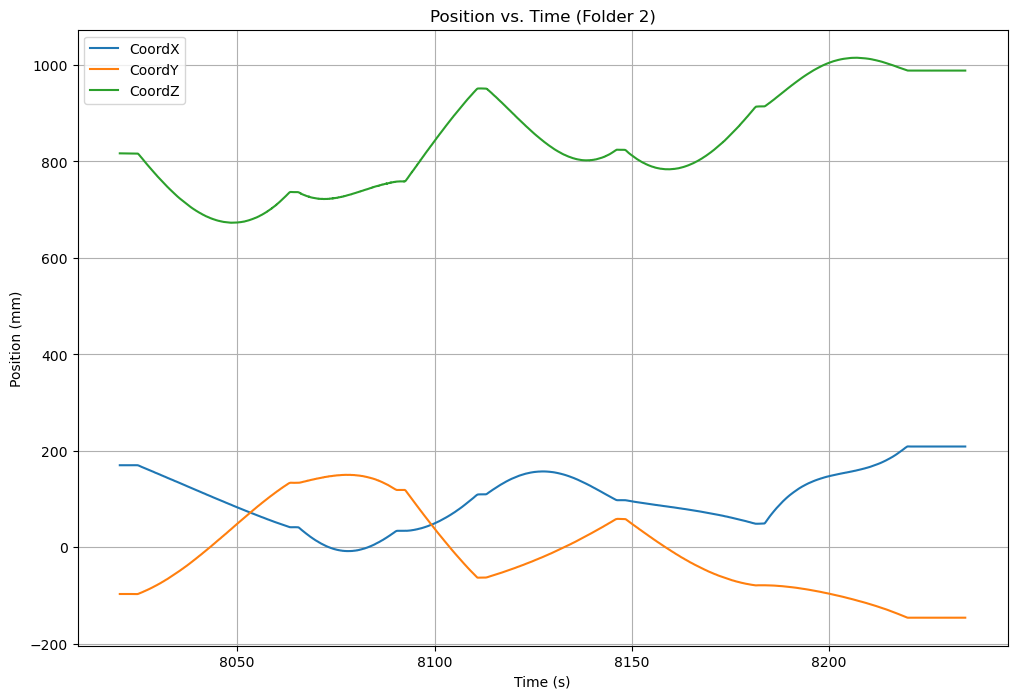

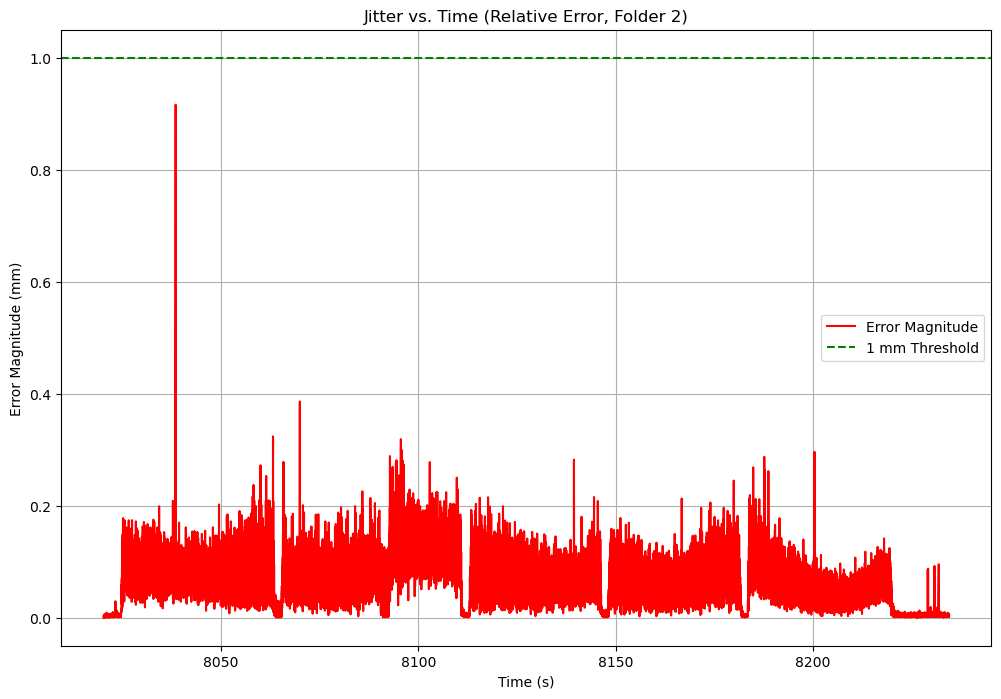

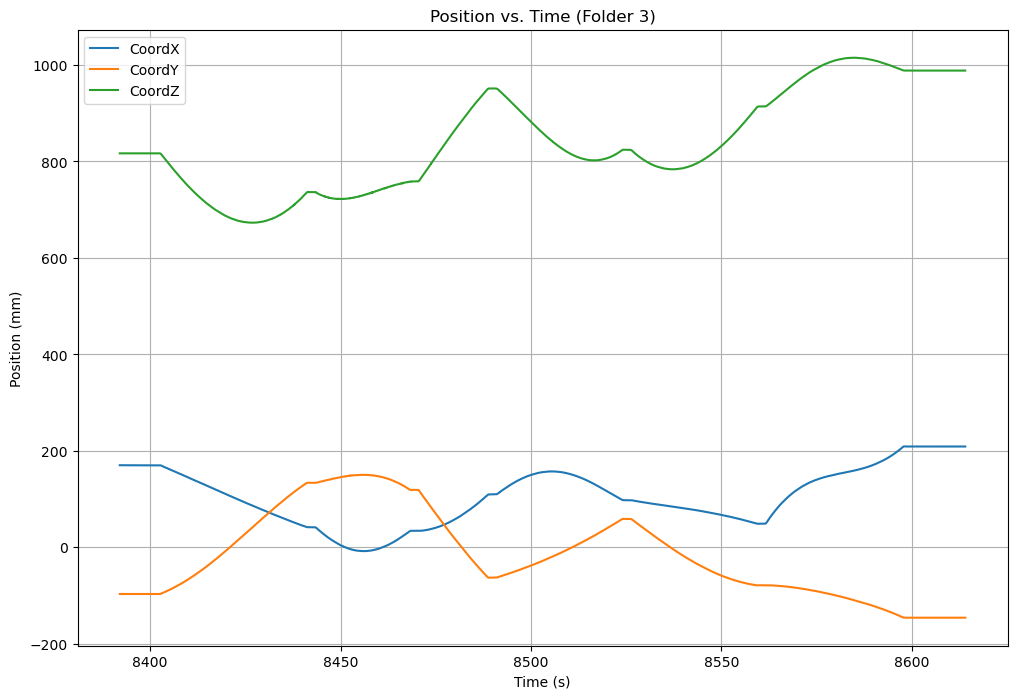

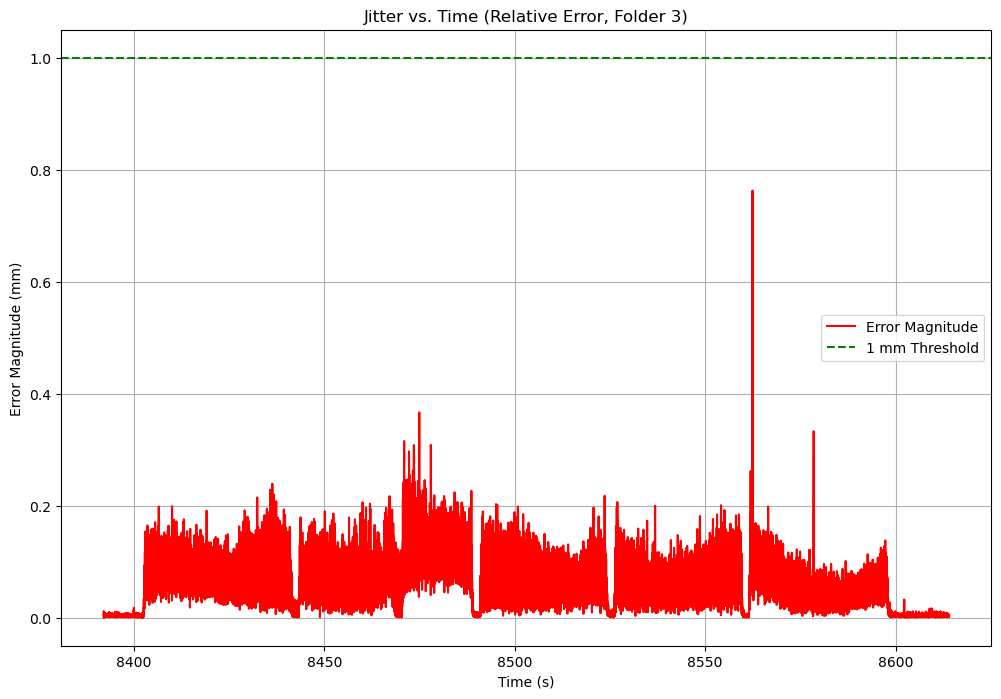

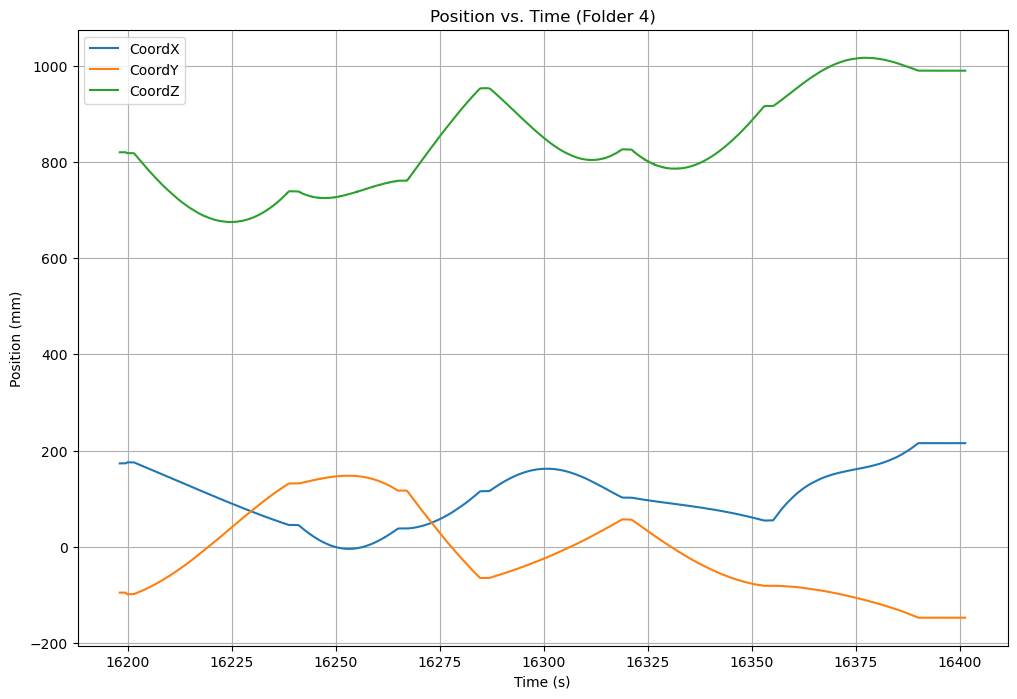

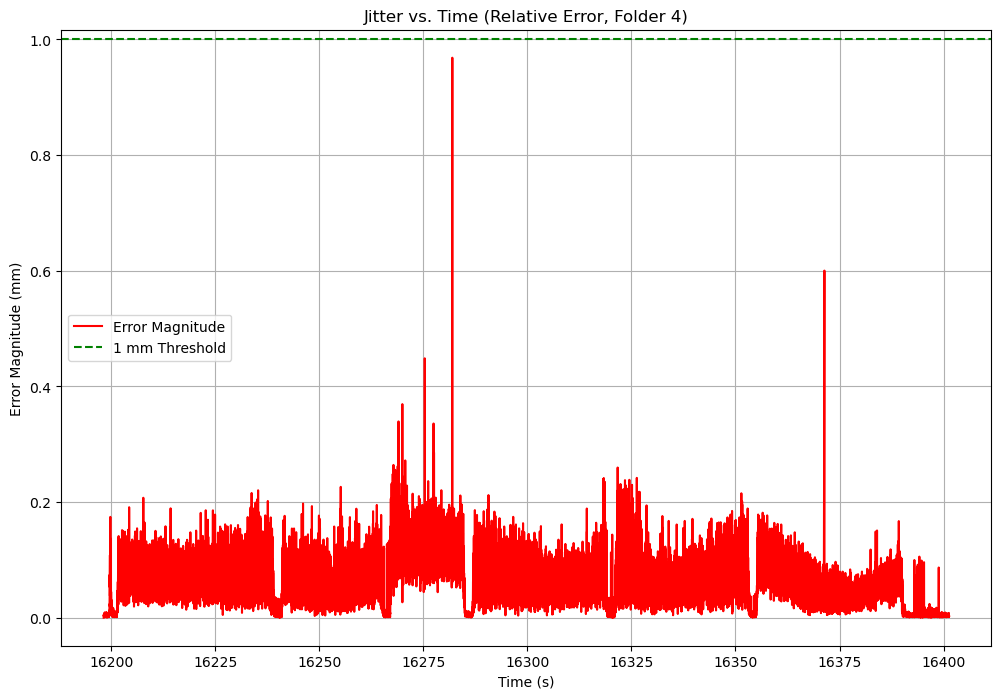

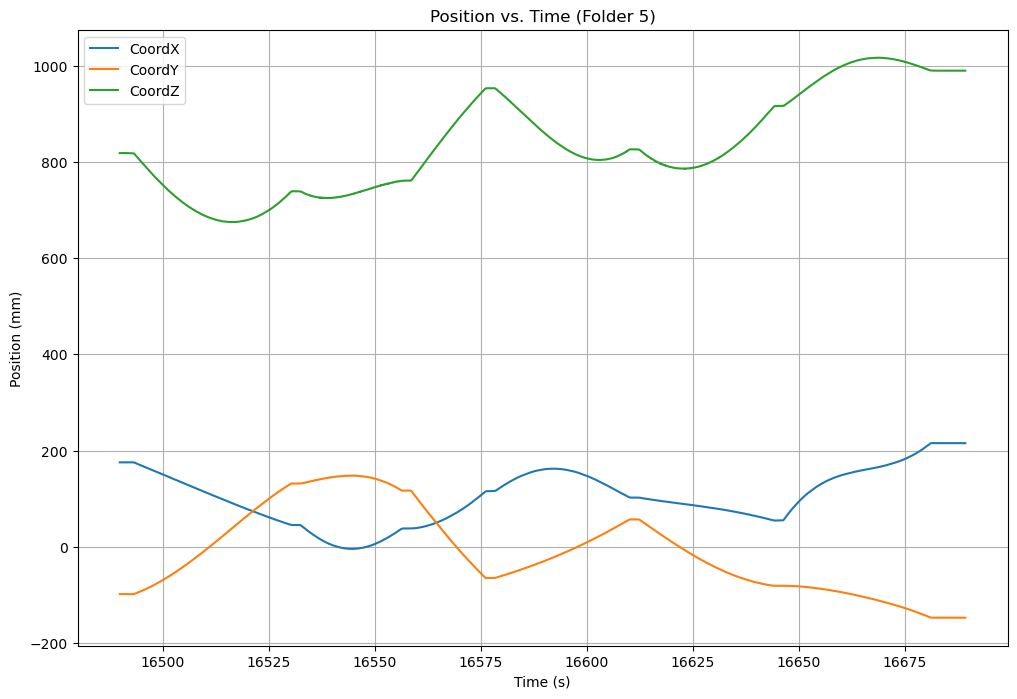

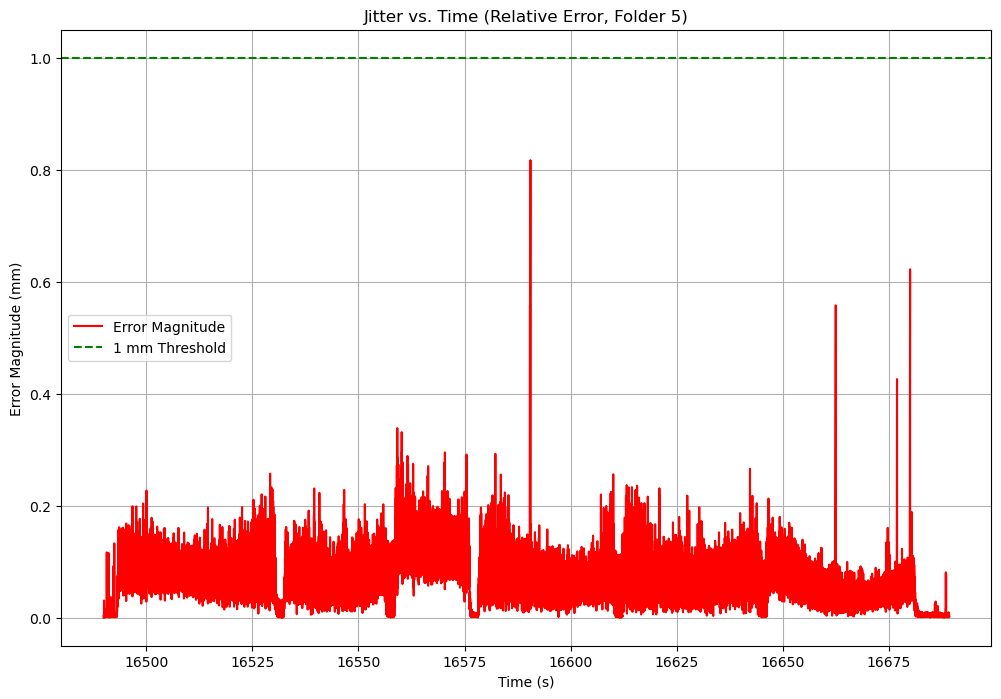

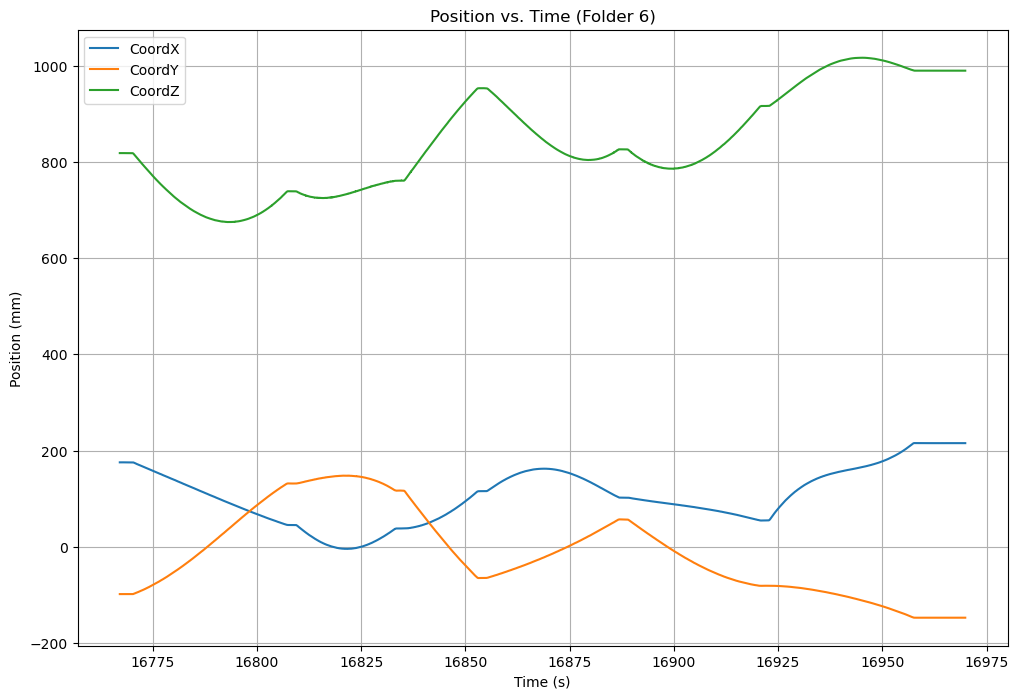

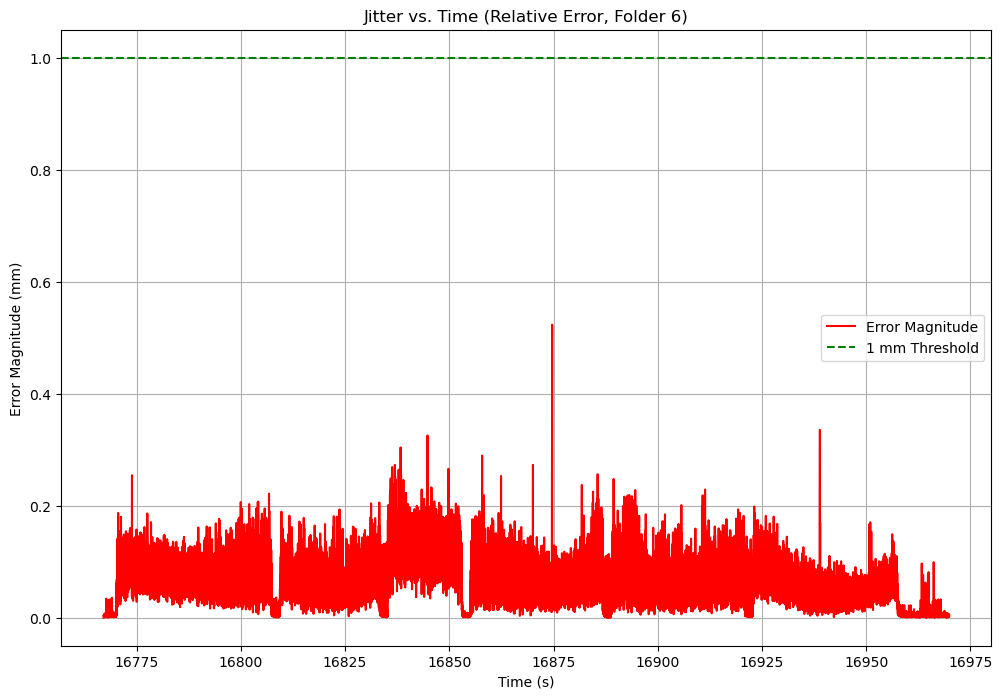

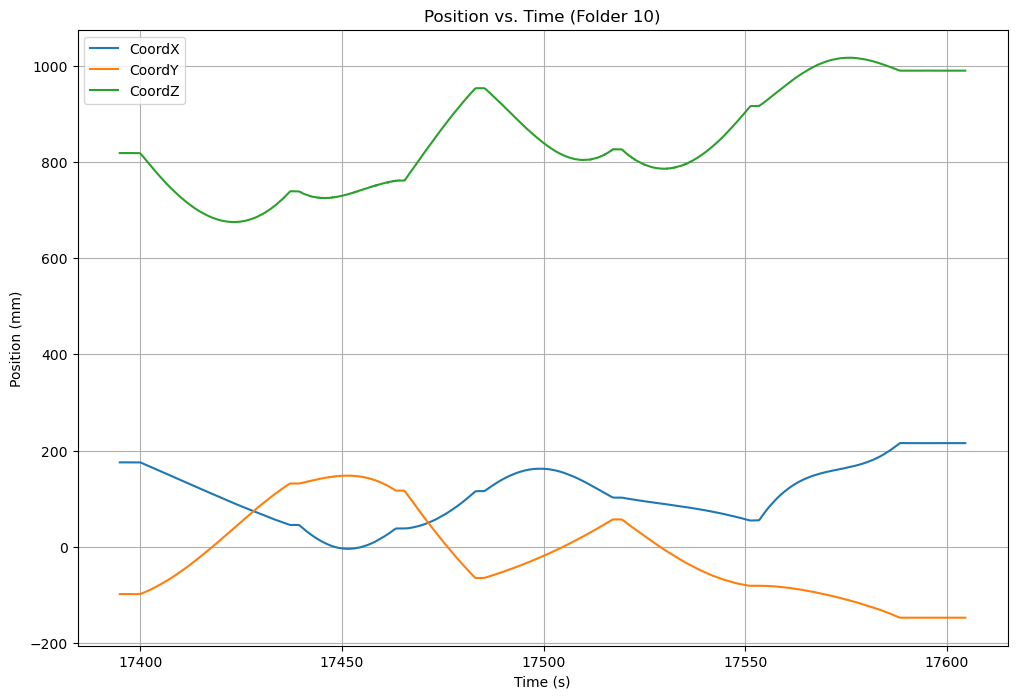

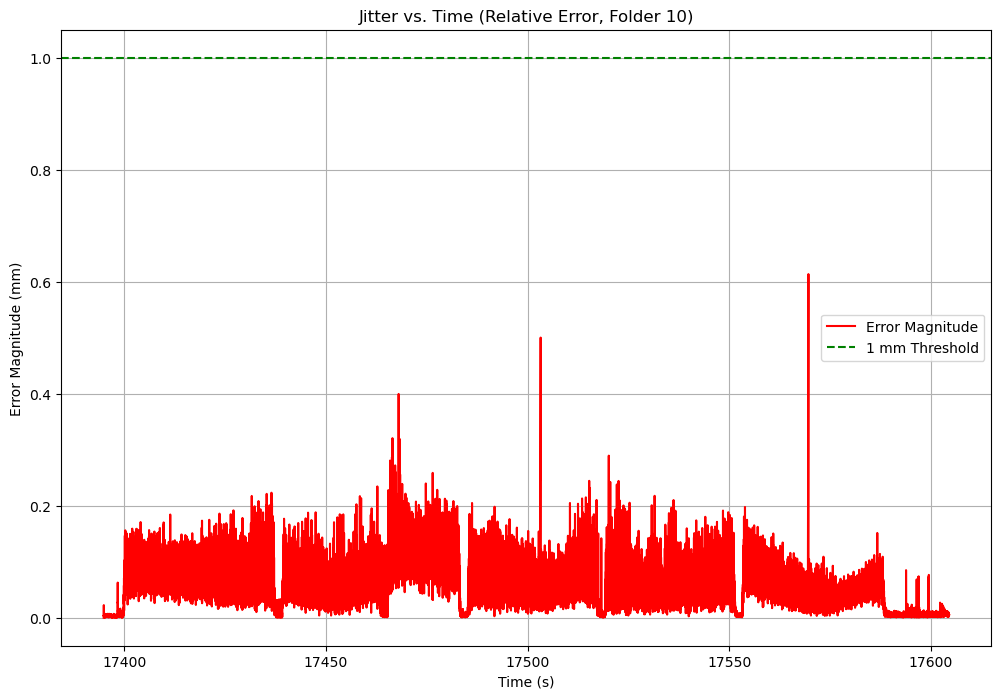

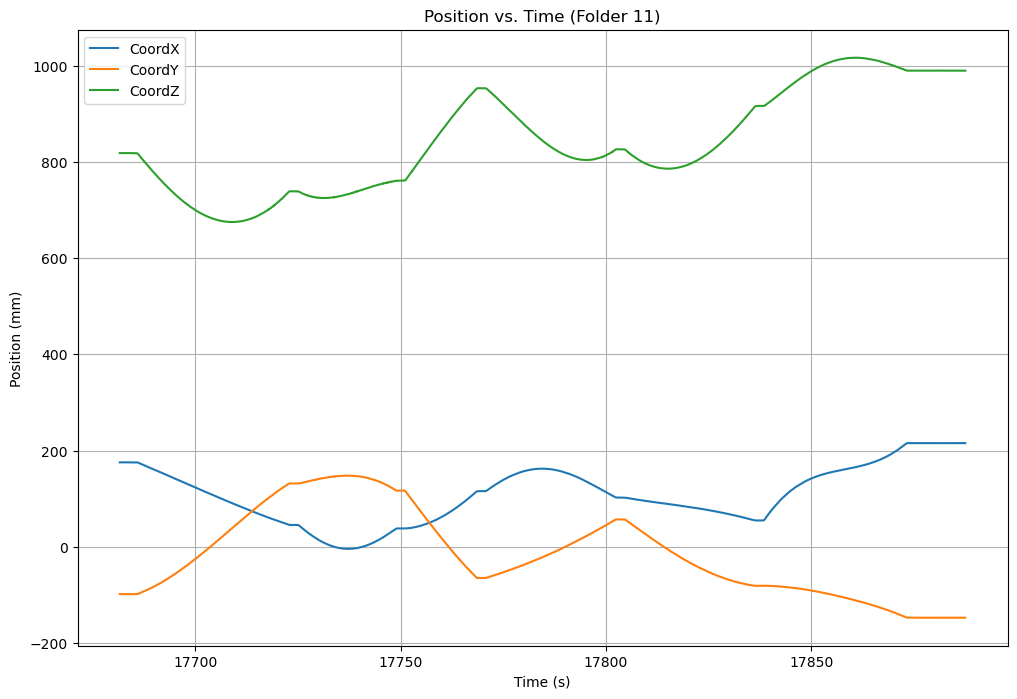

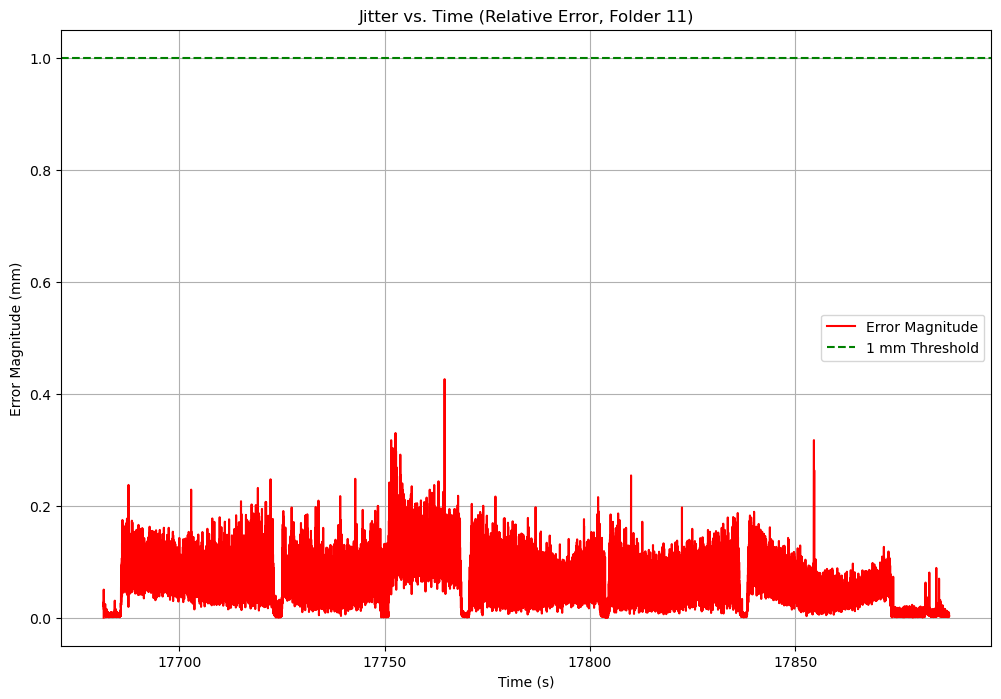

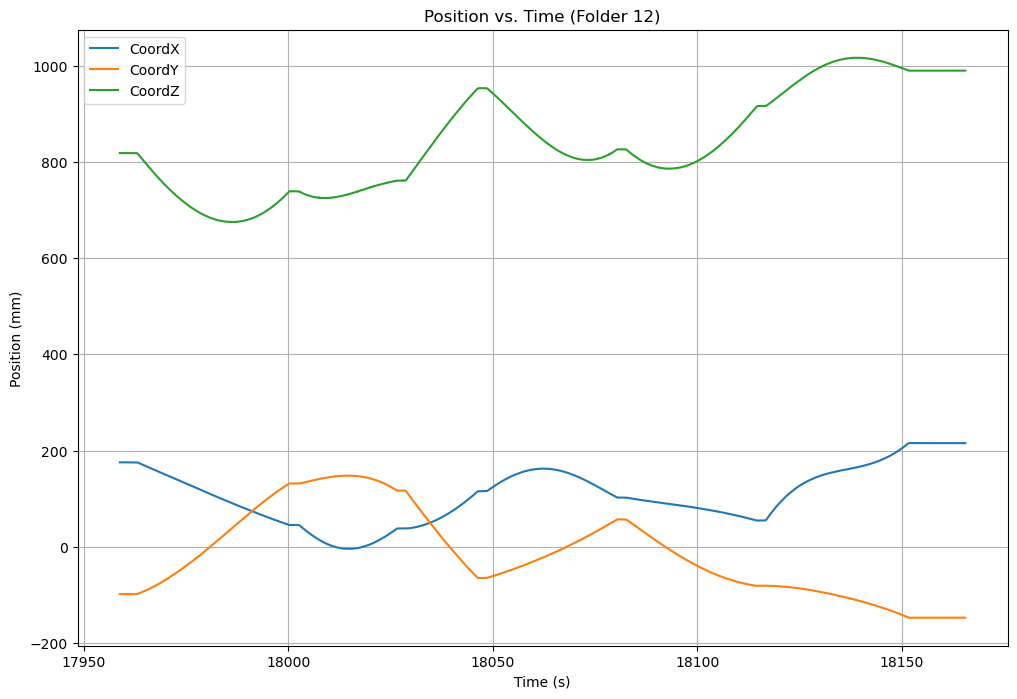

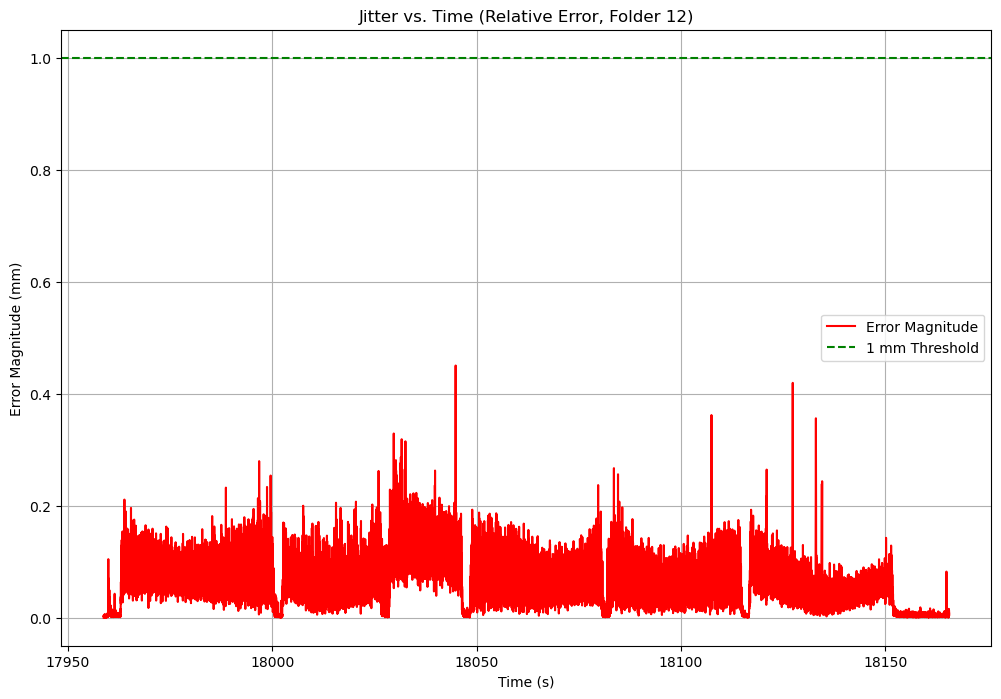

In [86]:
output_folder = "results/position_jitter"  # Replace with desired path
os.makedirs(output_folder, exist_ok=True)

# Analyze position jitter for all processed data
all_position_metrics = analyze_all_position_jitter(processed_data, output_folder)

# Example: Access metrics for folder 1
#print(f"Folder 1 Metrics: {all_position_metrics[1]}")


In [87]:
def check_position_error_threshold(all_position_metrics):
    """
    Checks whether the maximum error magnitude exceeds 1 mm for all folders.
    :param all_position_metrics: Dictionary containing position metrics for all folders.
    :return: Dictionary with pass/fail status and max error for each folder.
    """
    position_results = {}
    for folder_label, metrics in all_position_metrics.items():
        max_error = metrics['Max_Error']
        exceeded = metrics['Exceeded_Limit']
        position_results[folder_label] = {
            'Max_Error': max_error,
            'Pass/Fail': 'Fail' if exceeded else 'Pass'
        }
    return position_results


In [88]:
def create_summary_csv(all_jitter_metrics, position_results, output_path):
    """
    Creates a summary CSV showing jitter metrics and position error results for all folders.
    :param all_jitter_metrics: Dictionary containing accelerometer jitter metrics for all folders.
    :param position_results: Dictionary containing position jitter results for all folders.
    :param output_path: Path to save the summary CSV.
    """
    summary_data = []

    for folder_label in sorted(all_jitter_metrics.keys()):
        # Analyze accelerometer jitter metrics
        jitter_metrics = all_jitter_metrics[folder_label]
        max_freqs = {axis: jitter_metrics[axis]['frequencies'][np.argmax(jitter_metrics[axis]['amplitudes'])] for axis in ['X', 'Y', 'Z']}
        max_amps = {axis: max(jitter_metrics[axis]['amplitudes']) for axis in ['X', 'Y', 'Z']}
        accel_fail = any(amp > 1 for amp in max_amps.values())

        # Get position error results
        max_position_error = position_results[folder_label]['Max_Error']
        position_fail = position_results[folder_label]['Pass/Fail'] == 'Fail'

        # Append results to summary
        summary_data.append({
            'Folder': folder_label,
            'Max Accel Freq X (Hz)': max_freqs['X'],
            'Max Accel Amp X': max_amps['X'],
            'Max Accel Freq Y (Hz)': max_freqs['Y'],
            'Max Accel Amp Y': max_amps['Y'],
            'Max Accel Freq Z (Hz)': max_freqs['Z'],
            'Max Accel Amp Z': max_amps['Z'],
            'Accel Pass/Fail': 'Fail' if accel_fail else 'Pass',
            'Max Position Error (mm)': max_position_error,
            'Position Pass/Fail': 'Fail' if position_fail else 'Pass'
        })

    # Save summary to CSV
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv(output_path, index=False)
    print(f"Summary CSV saved to {output_path}")


In [89]:
# Analyze position results
position_results = check_position_error_threshold(all_position_metrics)

# Create summary CSV
summary_csv_path = "results/summary_all_folders.csv"  # Replace with desired path
create_summary_csv(all_jitter_metrics, position_results, summary_csv_path)

Summary CSV saved to results/summary_all_folders.csv
